In [1]:
import torch
import gpytorch
import numpy as np
import optuna
import matplotlib.pyplot as plt
from src.plotting import plot_gp, plot_alpha_beta, plot_train_test_split

from src.data_loader import PVDataLoader
from src import data_loader as dl
from src.models import ExactGPModel, BetaGP
from src.beta_likelihood import BetaLikelihood_MeanParametrization
from optuna.visualization import plot_optimization_history, plot_param_importances

In [2]:
# set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# data parameters
DAY_INIT = 10
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 5
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL
N_SYSTEMS = 15
RADIUS = 0.35
COORDS = (55, -1.5)
IDX = 6

/Users/eirikbaekkelund/Desktop/UCL/Code
==> Loading data
==> Loaded data in: 0 m : 6 sec

/Users/eirikbaekkelund/Desktop/UCL/Code
==> Loading data
==> Loaded data in: 0 m : 0 sec



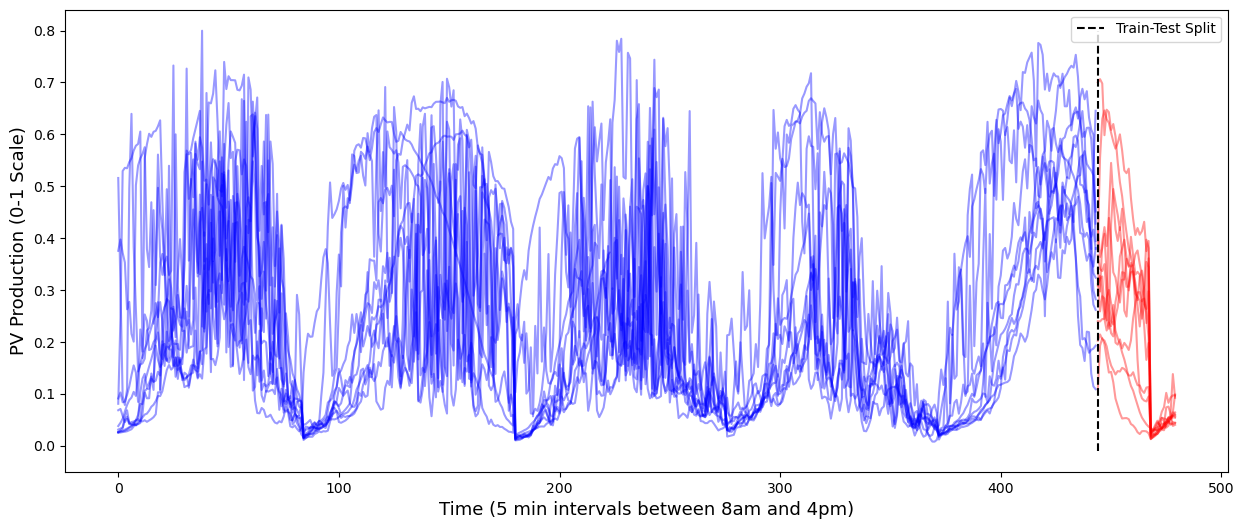

In [3]:
loader = PVDataLoader(n_days=N_DAYS,
                    day_init=DAY_INIT,
                    n_systems=N_SYSTEMS,
                    radius=RADIUS,
                    coords=COORDS,
                    minute_interval=MINUTE_INTERVAL,
                    day_min=DAY_MIN,
                    day_max=DAY_MAX,
                    folder_name='pv_data',
                    file_name_pv='pv_data_clean.csv',
                    file_name_location='location_data_clean.csv')

time, y = loader.get_time_series()
x_train, y_train, x_test, y_test = dl.train_test_split(time, y, n_hours=3)
plot_train_test_split(y_train, y_test)

In [4]:
def periodic_mapping(time_steps, day_min, day_max, minute_interval):
    """ 
    Create a periodic mapping of time steps to a sine function to 
    capture the periodicity of the data.

    Args:
        time_steps (torch.Tensor): time steps to map
        day_min (int): minimum time of the day
        day_max (int): maximum time of the day
        minute_interval (int): interval between time steps in minutes

    Returns:
        torch.Tensor: mapped time steps to sine function
    """
    total_minutes = (day_max - day_min) * 60  # Total number of minutes in the specified time range
    normalized_minutes = (time_steps * minute_interval) % total_minutes  # Normalize time steps to minutes

    # Apply periodic mapping using sine function
    mapped_values = torch.sin(2 * torch.pi * normalized_minutes / total_minutes)
    
    return mapped_values

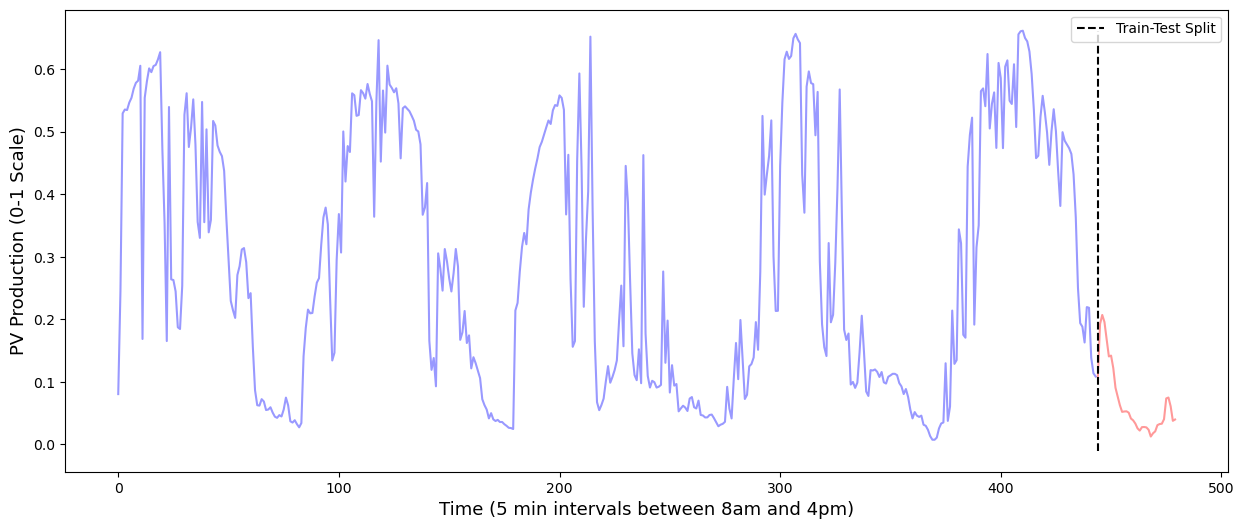

In [44]:
# get individual time series
IDX = 10
y_in = y[:, IDX]

if y_in.max() > 1:
    y_in[y_in > 1] = 1
# get time related variables
periodic_time = periodic_mapping(time, DAY_MIN, DAY_MAX, MINUTE_INTERVAL)
x = torch.stack([time, periodic_time], dim=1)

# standardize input
x = (x - x.mean(dim=0)) / x.std(dim=0)

# split into train and test
x_train, y_train, x_test, y_test = dl.train_test_split(x, y_in, n_hours=3)

plot_train_test_split(y_train, y_test)

# use all data as inducing points
x_inducing = x_train
y_inducing = y_train

# Stochastic Variational Inference for Gaussian Processes

Limitations:
- stochastic updates which can cause optimization problems and no guarantee of the global optimum is guaranteed, careful initialization and tuning of hyperparameters.
- not exact training data but inducing points (hyperparameter choice)
- not closed form solution for posterior s.t. solution is not exact


Strengths:
- non-gaussian likelihood for flexibility
- scalability
- uncertainty estimation
- approximate inference can capture important aspects of the underlying disitribtuions (giving fairly accurate predictions)

# Kernels

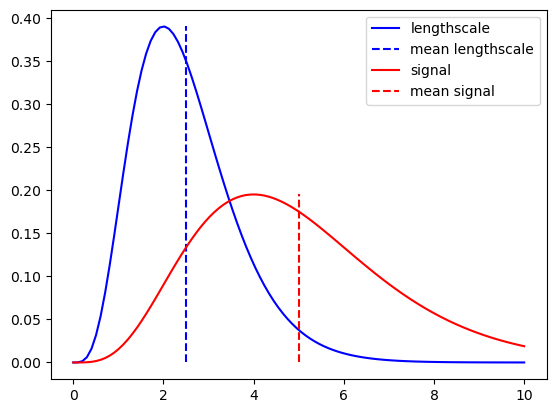

In [45]:
con1, r1 = 5, 2
con2, r2 = 5, 1

dist_1 = torch.distributions.Gamma(concentration=con1, rate=r1)
dist_2 = torch.distributions.Gamma(concentration=con2, rate=r2)

mean1 = dist_1.mean
mean2 = dist_2.mean

xx = torch.linspace(0.001, 10, 100)
y1 = dist_1.log_prob(xx).exp()
y2 = dist_2.log_prob(xx).exp()

plt.plot(xx, y1, label='lengthscale', color='b')
plt.vlines(mean1, 0, y1.max(), label='mean lengthscale', color='b', linestyles='dashed')

plt.plot(xx, y2, label='signal', color='r')
plt.vlines(mean2, 0, y2.max(), label='mean signal', color='r', linestyles='dashed')
plt.legend()
plt.show()

In [46]:
from gpytorch.kernels import MaternKernel, ScaleKernel, AdditiveKernel, ProductKernel, PeriodicKernel
from gpytorch.means import ConstantMean
# TODO add a prior to the lengthscale in matern, and the period in periodic
# BEST INITS
# matern = MaternKernel(nu=5/2, ard_num_dims=x.shape[1], lengthscale_prior=gpytorch.priors.NormalPrior(1, 0.1))
# kernel = ScaleKernel(matern, lengthscale_prior=gpytorch.priors.NormalPrior(0.5, 0.2))

matern = MaternKernel(nu=5/2, 
                      ard_num_dims=x.shape[1], 
                      lengthscale_prior=gpytorch.priors.GammaPrior(5, 2),
                      lengthscale_constraint=gpytorch.constraints.Positive()
                      )
periodic = PeriodicKernel(period_length_prior=gpytorch.priors.GammaPrior(5, 2),
                            period_length_constraint=gpytorch.constraints.Positive()
                        )
scaled_matern = ScaleKernel(periodic * matern, 
                            outputscale_prior=gpytorch.priors.GammaPrior(5, 1),
                            outputscale_constraint=gpytorch.constraints.Positive()
                            )

In [75]:
from gpytorch.likelihoods import GaussianLikelihood
from src.models import ApproximateGPBaseModel

class TruncatedGaussianLikelihood(GaussianLikelihood):
    def __init__(self, scale, a, b, *args, **kwargs):
        self.scale = scale
        self.a = a
        self.b = b
        super().__init__(*args, **kwargs)

    def forward(self, target, function_samples, *args, **kwargs):
        # get mode of function samples pointwise

        mode = function_samples.mode()
        diff = target - mode
        
        normal = torch.distributions.Normal(0, 1)

        numerator = self.scale * normal.log_prob(self.scale * diff).exp()
        denominator = normal.cdf(self.scale * (self.b - mode)) - normal.cdf(self.scale * (self.a - mode))

        return numerator / denominator

class TruncatedGP(ApproximateGPBaseModel):
    def __init__(self,
                  X : torch.Tensor, 
                  y : torch.Tensor,
                  mean_module : gpytorch.means.Mean,
                  covar_module : gpytorch.kernels.Kernel,
                  likelihood : gpytorch.likelihoods.Likelihood,
                  config : dict,
                  jitter : float = 1e-4,
                 ):
        
        assert y.min() >= 0 and y.max() <= 1, 'y must be in the range [0, 1] for Beta likelihood'
        assert X.size(0) == y.size(0), 'X and y must have same number of data points'
        
        # add perturbation to the data to avoid numerical issues for bounded outputs
        if y.min() == 0:
            y += jitter
        
        if y.max() == 1:
            y -= jitter
        
        super(TruncatedGP, self).__init__(train_x=X, 
                                          train_y=y, 
                                          mean_module=mean_module, 
                                          covar_module=covar_module, 
                                          likelihood=likelihood, 
                                          config=config, 
                                          jitter=jitter)
    

In [76]:
jitter = 1e-4
config = {'type': 'stochastic',
          'name': 'cholesky',
          'num_inducing_points': x_inducing.size(0),
          'mean_init_std': 1,
}

inputs_mean = {'X': x_train, 'y': y_train, 
               'mean_module': gpytorch.means.ZeroMean(),
               'covar_module': scaled_matern,
               'likelihood': TruncatedGaussianLikelihood(scale=60, a=0, b=1),
                'config': config,
                'jitter': jitter
            }

model_tg = BetaGP(**inputs_mean)
model_tg.fit(n_iter=150, lr=0.05, optim=torch.optim.Adam, device=torch.device('cpu'))

AttributeError: 'TruncatedGaussianLikelihood' object has no attribute 'raw_scale'

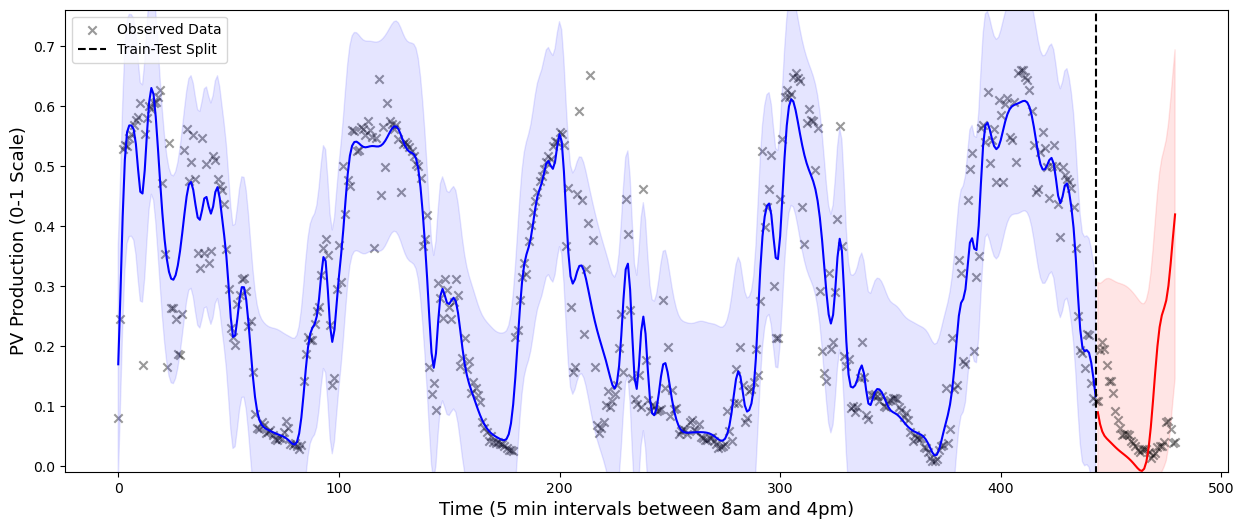

In [74]:
preds = model_tg.predict(x_test, device=torch.device('cpu'))
plot_gp(model_tg, x_train, x_test, y_train, y_test, y_inducing=y_inducing, pred_type='mean')

In [62]:
jitter = 1e-3
config = {'type': 'stochastic',
          'name': 'cholesky',
          'num_inducing_points': x_inducing.size(0),
          'mean_init_std': 1,
}

inputs_mean = {'X': x_train, 'y': y_train, 
               'mean_module': gpytorch.means.ConstantMean(),
               'covar_module': scaled_matern,
               'likelihood': BetaLikelihood_MeanParametrization(scale=10),
                'config': config,
                'jitter': jitter
            }

model_beta = BetaGP(**inputs_mean)
model_beta.fit(n_iter=500, lr=0.2, optim=torch.optim.Adam, device=torch.device('cpu'))


Iter 50/500 - Loss: -0.563
Iter 100/500 - Loss: -0.767
Iter 150/500 - Loss: -0.838
Iter 200/500 - Loss: -0.835
Iter 250/500 - Loss: -0.838
Iter 300/500 - Loss: -0.569
Iter 350/500 - Loss: 0.186
Iter 400/500 - Loss: -0.759
Iter 450/500 - Loss: -0.371
Iter 500/500 - Loss: -0.872


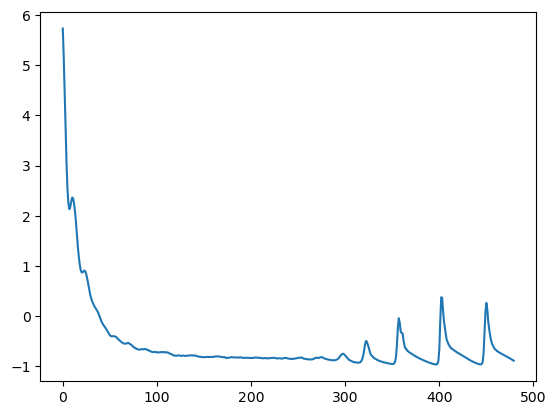

In [60]:
plt.plot(model_beta.losses[20:]);

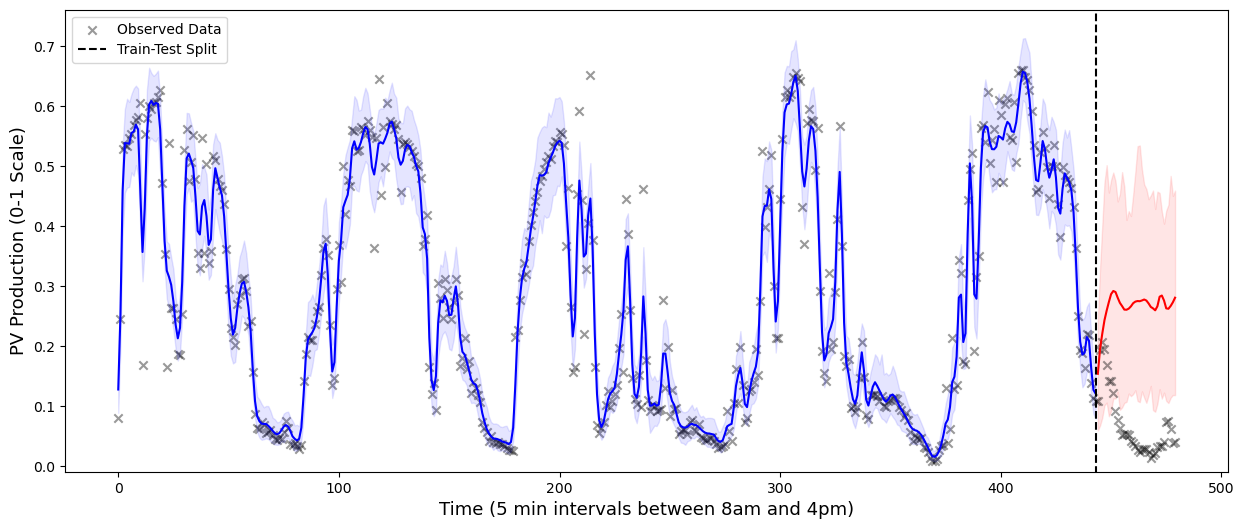

In [61]:
plot_gp(model=model_beta, 
        x_train=x_train,
        x_test=x_test,
        y_train=y_train,
        y_test=y_test,
        y_inducing=y_inducing,
        )

In [13]:
model_exact = ExactGPModel(X=x_train, 
                           y=y_train,
                           likelihood=gpytorch.likelihoods.GaussianLikelihood(),
                            mean_module=gpytorch.means.ZeroMean(),
                            covar_module=scaled_matern)

model_exact.fit(n_iter=150, lr=0.3, optim=torch.optim.Adam, device=torch.device('cpu'))

Iter 15/150 - Loss: -0.535
Iter 30/150 - Loss: -0.789
Iter 45/150 - Loss: -0.825
Iter 60/150 - Loss: -0.842
Iter 75/150 - Loss: -0.846
Iter 90/150 - Loss: -0.847
Iter 105/150 - Loss: -0.847
Iter 120/150 - Loss: -0.847
Iter 135/150 - Loss: -0.847
Iter 150/150 - Loss: -0.847


/Users/eirikbaekkelund/opt/anaconda3/envs/gp/lib/python3.11/site-packages/gpytorch/models/exact_gp.py:274: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


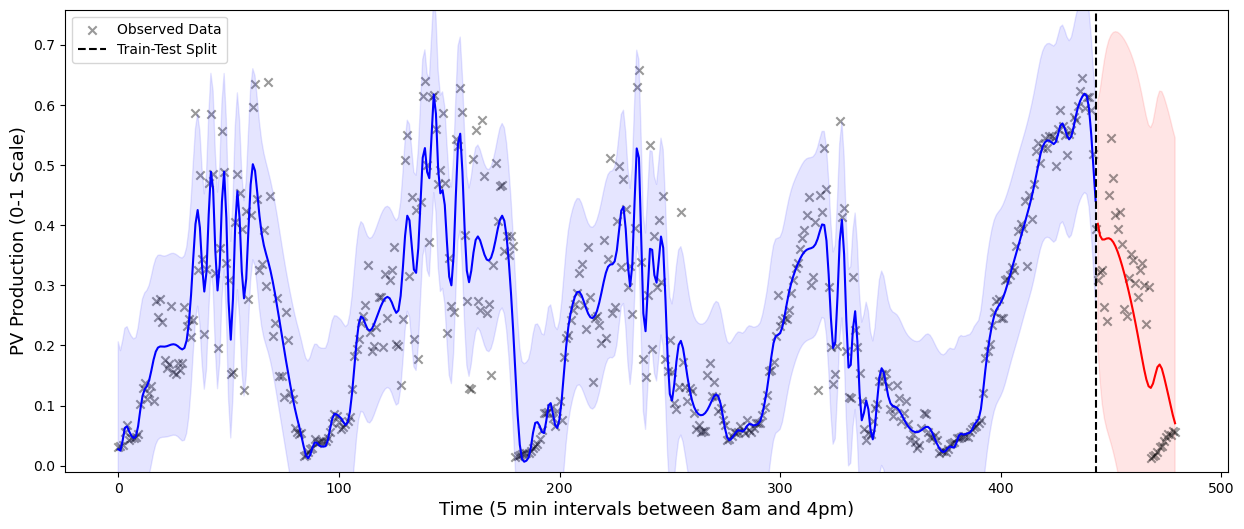

In [14]:
plot_gp(model=model_exact, 
        x_train=x_train,
        x_test=x_test,
        y_train=y_train,
        y_test=y_test,
        )

# Hyperparameter Optimization

In [107]:
class HyperParameterOptimization:
    """ 
    Hyperparameter optimization using Optuna.

    Args:
        model (gpytorch.models.Model): model to optimize
        x_train (torch.Tensor): training inputs
        y_train (torch.Tensor): training targets
        x_test (torch.Tensor): test inputs
        y_test (torch.Tensor): test targets
    """

    def __init__(self, 
                 model : str,
                 x_train : torch.Tensor,
                 y_train : torch.Tensor,
                 x_test : torch.Tensor,
                 y_test : torch.Tensor,
                ):
        assert model in ['beta', 'exact']
        self.model = model
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test

    def sample_params_matern(self,
                             trial : optuna.trial.Trial
                             ):
        """ 
        Sample hyperparameters for the model.

        Args:
            trial (optuna.trial.Trial): Optuna
        
        Returns:
            dict: dictionary of hyperparameters
        """
        
        # sample hyperparameters
        matern_nu = trial.suggest_categorical('matern_nu', [3/2, 5/2])
        
        lengthscale_shape = trial.suggest_float('lengthscale_shape', 1, 10, step=1)
        lengthscale_rate = trial.suggest_float('lengthscale_rate', 1, 10, step=1)

        signal_shape = trial.suggest_float('signal_shape', 1, 10, step=1)
        signal_rate = trial.suggest_float('signal_rate', 1, 10, step=1)
        
        # create kernel
        matern = MaternKernel(nu=matern_nu,
                              lengthscale_prior=gpytorch.priors.GammaPrior(lengthscale_shape, lengthscale_rate),
                              lengthscale_constraint=gpytorch.constraints.Positive()
                                )
        scaled_matern = ScaleKernel(matern,
                                    outputscale_prior=gpytorch.priors.GammaPrior(signal_shape, signal_rate),
                                    outputscale_constraint=gpytorch.constraints.Positive()
                                    )
        return scaled_matern
    
    def sample_params_likelihood(self,
                                 trial : optuna.trial.Trial
                                ):
        """
        Sample hyperparameters for the likelihood.

        Args:
            trial (optuna.trial.Trial): Optuna
        
        Returns:
            likelihood (gpytorch.likelihoods.Likelihood): likelihood of the model
        """
        likelihood_scale = trial.suggest_float('likelihood_scale', 40, 100, step=5)
        likelihood = BetaLikelihood_MeanParametrization(scale=likelihood_scale)

        return likelihood                                      

    def get_config(self,
                   config : dict,
                   kernel : gpytorch.kernels.Kernel,
                   likelihood : gpytorch.likelihoods.Likelihood,
                   jitter : float):
        """
        Get the configuration of the model.

        Args:
            config (dict): configuration of the model
            kernel (gpytorch.kernels.Kernel): kernel of the model
            likelihood (gpytorch.likelihoods.Likelihood): likelihood of the model
            jitter (float): jitter for the cholesky decomposition
        
        Returns:
            inputs (dict): dictionary of inputs for the model
        """
        config = {
            'type': 'stochastic',
            'name': 'mean_field',
            'num_inducing_points': self.x_train.size(0),
            # TODO maybe change mean_init_std to a prior
            'mean_init_std': 1,
        }

        inputs = {
            'X': self.x_train,
            'y': self.y_train,
            'mean_module': gpytorch.means.ConstantMean(),
            'covar_module': kernel,
            'likelihood': likelihood,
            'config': config,
            'jitter': jitter
        }

        return inputs
    

    def train(self,
              inputs : dict,
              trial : optuna.trial.Trial
              ):
        """ 
        Train the model with the sampled hyperparameters.

        Args:
            inputs (dict): dictionary of inputs for the model
            trial (optuna.trial.Trial): Optuna
        
        Returns:
            float: negative log likelihood
        """
        if self.model == 'beta':
            model = BetaGP(**inputs)
        elif self.model == 'exact':
            model = ExactGPModel(**inputs)
        
        #n_iter = trial.suggest_int('n_iter', 100, 500, step=100)
        lr = trial.suggest_float('lr', 0.01, 0.5)

        model.fit(n_iter=300, 
                  lr=lr, 
                  optim=torch.optim.Adam, 
                  device=torch.device('cpu'),
                  verbose=False)
        
        model.predict(self.x_test, device=torch.device('cpu'))

        with torch.no_grad():
            trained_pred_dist = model.likelihood(model(self.x_test))
        
        nlpd = gpytorch.metrics.negative_log_predictive_density(trained_pred_dist, self.y_test)
        # msll = gpytorch.metrics.mean_standardized_log_loss(self.y_test, trained_pred_dist.mean)
        return nlpd.mean()
        
    def objective(self,
                  trial : optuna.trial.Trial,
                  config : dict,
                  jitter : float
                 ):
        """ 
        Objective function for Optuna.

        Args:
            trial (optuna.trial.Trial): Optuna
        
        Returns:
            float: negative log predictive density
        """
        kernel = self.sample_params_matern(trial)
        likelihood = self.sample_params_likelihood(trial)
        inputs = self.get_config(config, kernel, likelihood, jitter)
        
        try:
            inputs = self.get_config(config, kernel, likelihood, jitter)
            loss = self.train(inputs, trial)
        
        # if not PSD --> except the trial, add jitter, and try again
        except:
            inputs = self.get_config(config, kernel, likelihood, jitter*10)
            loss = self.train(inputs, trial)

        return loss

In [108]:
config = {'type': 'stochastic',
            'name': 'mean_field',
            'num_inducing_points': x_train.size(0),
            'mean_init_std': 1,
            }

jitter = 1e-5

In [ ]:
hyper_opt = HyperParameterOptimization( model='beta',
                                        x_train=x_train,
                                        y_train=y_train,
                                        x_test=x_test,
                                        y_test=y_test,
)
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: hyper_opt.objective(trial, config, jitter), n_trials=100)

In [110]:
from optuna.visualization import plot_optimization_history, plot_contour, plot_edf, plot_parallel_coordinate, plot_param_importances, plot_slice, plot_intermediate_values

In [111]:
plot_optimization_history(study)

In [130]:
plot_contour(study, params=[ 'lengthscale_rate', 'lengthscale_shape'])

In [113]:
plot_parallel_coordinate(study)

In [115]:
plot_param_importances(study)

In [148]:
best_params = study.best_params
best_params

{'matern_nu': 2.5,
 'lengthscale_shape': 4.0,
 'lengthscale_rate': 8.0,
 'signal_shape': 3.0,
 'signal_rate': 2.0,
 'likelihood_scale': 60.0,
 'lr': 0.29982159381001894}

In [149]:
kernel = ScaleKernel(MaternKernel(nu=best_params['matern_nu'],
                                    lengthscale_prior=gpytorch.priors.GammaPrior(best_params['lengthscale_shape'], best_params['lengthscale_rate']),
                                    lengthscale_constraint=gpytorch.constraints.Positive()
                    ),
                    outputscale_prior=gpytorch.priors.GammaPrior(best_params['signal_shape'], best_params['signal_rate']),
                    outputscale_constraint=gpytorch.constraints.Positive()
                    )

likelihood = BetaLikelihood_MeanParametrization(scale=best_params['likelihood_scale']+100)

inputs = hyper_opt.get_config(config, kernel, likelihood, jitter)


In [150]:
model_beta = BetaGP(**inputs)
model_beta.fit(n_iter=500, lr=0.3, optim=torch.optim.Adam, device=torch.device('cpu'))

Iter 50/500 - Loss: 2.194
Iter 100/500 - Loss: 0.294
Iter 150/500 - Loss: -0.572
Iter 200/500 - Loss: -0.816
Iter 250/500 - Loss: -0.903
Iter 300/500 - Loss: -0.941
Iter 350/500 - Loss: -0.959
Iter 400/500 - Loss: -0.967
Iter 450/500 - Loss: -0.970
Iter 500/500 - Loss: -0.972


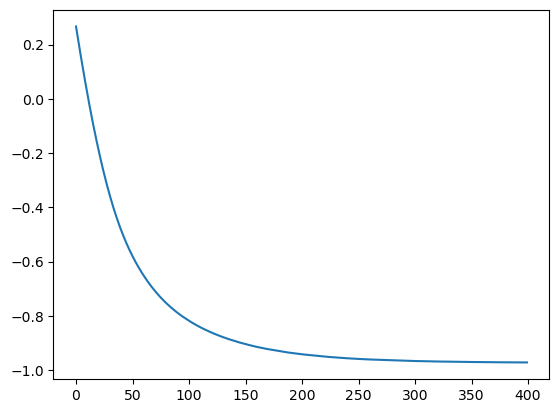

In [151]:
plt.plot(model_beta.losses[100:]);

In [152]:
with torch.no_grad():
    trained_pred_dist = model_beta.likelihood(model_beta(x_test))

nlpd = gpytorch.metrics.negative_log_predictive_density(trained_pred_dist, y_test)

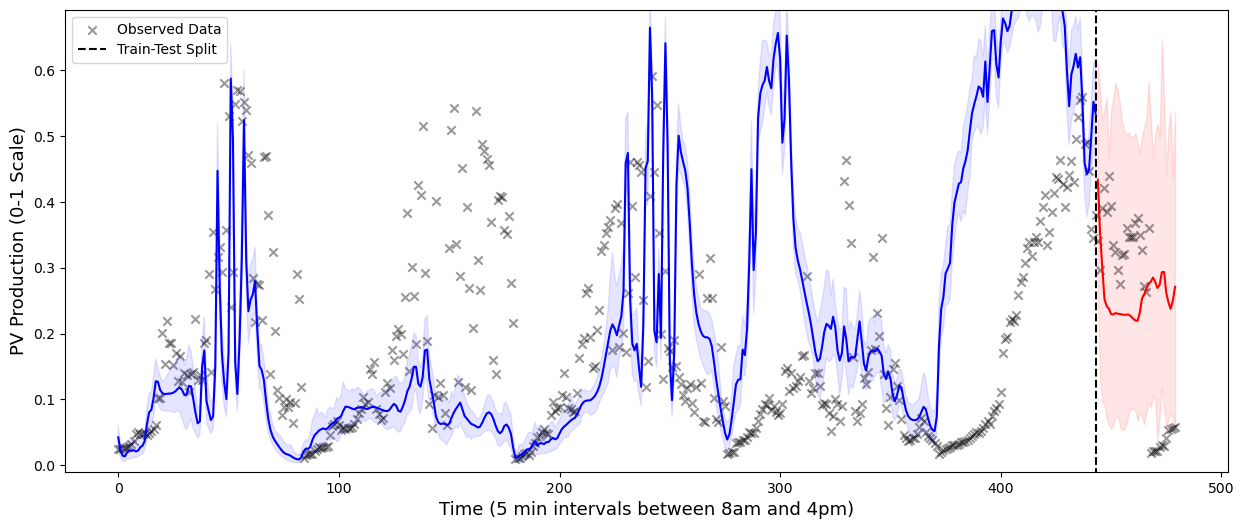

In [153]:
plot_gp(model=model_beta,
        x_train=x_train,
        x_test=x_test,
        y_train=y_train,
        y_test=y_test,
        y_inducing=y_inducing
        )